In [1]:
import os
import time
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchviz import make_dot
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.io import read_image


C:\Users\Onur\anaconda3\envs\torch_environment\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH_TRAIN_LABEL_CSV = r"D:\Onur\Projects\dog_vs_cat\data\train_label\image_label.csv"
PATH_TRAIN = r"D:\Onur\Projects\dog_vs_cat\data\train"

In [3]:
device = 'cuda' if torch.cuda.is_available() is True else 'cpu'
device = 'cpu'

In [4]:
class DCDataset(Dataset):

    def __init__(self, annotation_file: str, img_dir: str, transform=None, target_transform=None, with_label=True):
        self.df_label = pd.read_csv(annotation_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df_label)

    def __getitem__(self, idx):
        #         df_img_row = self.df_label.iloc[idx, :]
        #         img_path = os.path.join(self.img_dir, df_img_row[0])

        #         image = read_image(img_path)
        #         label = df_img_row[1]

        img_path = os.path.join(self.img_dir, self.df_label.iloc[idx, 0])

        image = read_image(img_path).float()
        label = self.df_label.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
class PlainCNN(nn.Module):
    def __init__(self):
        super(PlainCNN, self).__init__()
        
        
        self.relu = nn.ReLU()
        
        # Static Layers
        self.maxpool_std2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()

        # Conv Layers
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=1)  # 106 ( / 2 = 58)
        self.conv3 = nn.Conv2d(32, 64, 5)  # 52  ( / 2 = 26)
        # self.conv4 = nn.Conv2d(128, 196, 3)  # 52  ( / 2 = 26)

        # Fully-Connected Layers
        self.linear1 = nn.Linear(25 * 25 * 64, 500)  # 26*26*24
        self.linear2 = nn.Linear(500, 100)
        self.linear3 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool_std2(x)

        x = self.relu(self.conv2(x))
        x = self.maxpool_std2(x)

        x = self.relu(self.conv3(x))
        x = self.maxpool_std2(x)

        x = self.flatten(x)
        x = self.relu(self.linear1(x))

        x = self.relu(self.linear2(x))

        x = self.linear3(x)

        return x

In [6]:
all_train_dataset = DCDataset(
    annotation_file=PATH_TRAIN_LABEL_CSV,
    img_dir=PATH_TRAIN)

In [7]:
train_batch_size = 32
trainloader = DataLoader(all_train_dataset, batch_size=train_batch_size, shuffle=True)

In [8]:
model = PlainCNN()
model = model.to(device)

In [9]:
loss_func = nn.CrossEntropyLoss()
print('loss', loss_func)
optimizer = torch.optim.Adam(params=model.parameters())
print(optimizer)

loss CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [10]:
import sys
sys.path.append('..')

In [11]:
from torchxray import Xray
from torchxray.inspect import TraceArchitecture

In [12]:
X = next(iter(trainloader))[0]
X = X.to(device)
X.size()

torch.Size([32, 3, 224, 224])

In [13]:
xray = Xray(model, input_tensor=X)
xray.initialize()

Conv2d-0
ReLU-0
MaxPool2d-0
Conv2d-1
ReLU-1
MaxPool2d-1
Conv2d-2
ReLU-2
MaxPool2d-2
Flatten-0
Linear-0
ReLU-3
Linear-1
ReLU-4
Linear-2
creating sun folders
creating sub folder for  Conv2d-0
creating sub folder for  ReLU-0
creating sub folder for  MaxPool2d-0
creating sub folder for  Conv2d-1
creating sub folder for  ReLU-1
creating sub folder for  MaxPool2d-1
creating sub folder for  Conv2d-2
creating sub folder for  ReLU-2
creating sub folder for  MaxPool2d-2
creating sub folder for  Flatten-0
creating sub folder for  Linear-0
creating sub folder for  ReLU-3
creating sub folder for  Linear-1
creating sub folder for  ReLU-4
creating sub folder for  Linear-2


D:\Onur\Desktop\yl\project_xray\repo_xray\test\..\torchxray\inspect.py:173: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  module_count = len(self.arr_modules[self.arr_modules == module_common_name])


In [15]:
x = X[0]
x.size()

torch.Size([3, 224, 224])

Epoch: 0 Batch: 0
[1,     1] loss: 0.018


D:\Onur\Desktop\yl\project_xray\repo_xray\test\..\torchxray\xray.py:153: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  module_count = len(self.hooked_modules[self.hooked_modules == module_common_name])


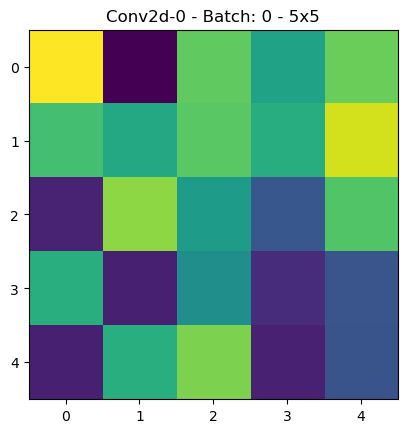

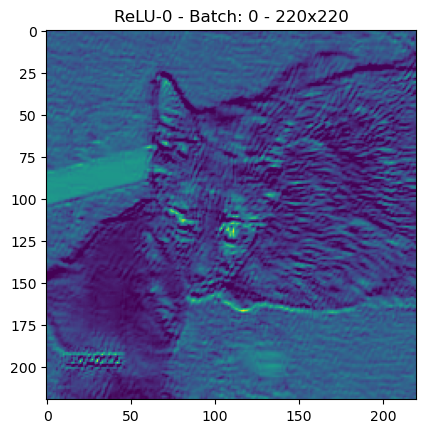

IndexError: index 28 is out of bounds for dimension 0 with size 16

In [17]:
start_time = time.time()

for epoch in range(2):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        print('Epoch:', epoch, 'Batch:', i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        report_interval = 500
        if i % report_interval == 0:  # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            xray.take_graph(x, batch_num=epoch*len(trainloader)+i, show_plot=True, save_plot=True)
            running_loss = 0.0

        print('Finished Training')

end_time = time.time()
print('Elapsed time:', int((end_time - start_time)/60), 'minutes')

In [19]:
print(X.shape)
model(X[0])

torch.Size([32, 3, 224, 224])


KeyError: 'Conv2d-4'

In [ ]:
outputs

In [ ]:
nn.CrossEntropyLoss()(outputs, labels)

In [ ]:
outputs

In [ ]:
labels